In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

from mpl_toolkits.axes_grid1 import make_axes_locatable

import math

from matplotlib import cm

import matplotlib.lines as mlines

%matplotlib inline

### AIR POLLUTION MONITORING DATA FROM EDF

In [199]:
df = pd.read_csv('EDF_Data.csv', header = 1)
df['TimePeriod'] = 'Jun2015-May2016'
df.head()

,Longitude,Latitude,NO Value,NO2 Value,BC Value,TimePeriod
0,-122.322594,37.806781,23.390071,17.539762,0.818032,Jun2015-May2016
1,-122.322310,37.806150,19.700000,19.956750,0.551475,Jun2015-May2016
2,-122.322301,37.806420,23.611111,23.967768,0.593712,Jun2015-May2016
3,-122.322299,37.805880,15.714285,18.435184,0.489898,Jun2015-May2016
4,-122.322267,37.806689,27.108695,25.797037,0.739341,Jun2015-May2016


In [200]:
df.shape

(21488, 6)

In [201]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

### Split the dataset into BC and NO2 since we are interested only in those two pollutants

In [202]:
df_BC = df[['Longitude', 'Latitude', 'BC Value', 'TimePeriod']]

In [203]:
df_NO2 = df[['Longitude', 'Latitude', 'NO2 Value', 'TimePeriod']]

### METEROLOGICAL DATASET

In [204]:
df_met = pd.read_csv("MetStations_CA.csv")
df_met.head()

,STATION_ID,STATION,BEGIN_DATE,END_DATE,STATE,COUNTRY,LATITUDE,LONGITUDE,ELEVATION_(M)
0,WBAN:23239,"ALAMEDA NAS, CA US",1945-02-28,1997-01-31,California,United States,37.78333,-122.31667,9.1
1,WBAN:94299,"ALTURAS MUNICIPAL AIRPORT, CA US",2004-12-31,2020-02-23,California,United States,41.49139,-120.56444,1333.5
2,WBAN:24283,"ARCATA EUREKA AIRPORT, CA US",1949-11-30,2020-02-23,California,United States,40.97806,-124.10861,61.0
3,WBAN:23224,"AUBURN MUNICIPAL AIRPORT, CA US",2004-12-31,2020-02-23,California,United States,38.95472,-121.08194,466.6
4,WBAN:23191,"AVALON CATALINA AIRPORT, CA US",1943-06-11,2020-02-23,California,United States,33.40500,-118.41583,488.3


In [205]:
crs = {'init': 'epsg:4326'}
geometry_met = [Point(xy) for xy in zip(df_met['LONGITUDE'], df_met['LATITUDE'])]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
geo_df_met = gpd.GeoDataFrame(df_met, crs = crs, geometry = geometry_met)

### FACILITY LEVEL DATA

In [206]:
# Read data for Oakland and drop duplicate facility ids
oak_facility = pd.read_csv('Data/oakland_facility_2017.csv', header = 0)
# Display all columns in the dataframe
oak_facility.columns

Index(['Unnamed: 0', 'county', 'eis facility id', 'agency facility id',
       'tri facility id', 'company name', 'site name', 'facility source type',
       'site latitude', 'site longitude', 'address', 'city', 'zip code',
       'pollutant code', 'pollutant type(s)', 'total emissions',
       'emissions uom', 'data set'],
      dtype='object')

In [207]:
# Drop columns that are not needed 
oak_facility.drop(columns = ['agency facility id', 'tri facility id','pollutant type(s)', 'data set', 'address',
                             'site name','facility source type','Unnamed: 0', 'county'], inplace=True)

In [208]:
# Rename site latitude and site longitude column to just latitude and logitude
oak_facility.rename(columns={"site latitude": "latitude", "site longitude": "longitude"}, inplace=True)

In [209]:
# Display all columns in the dataframe
oak_facility.columns

Index(['eis facility id', 'company name', 'latitude', 'longitude', 'city',
       'zip code', 'pollutant code', 'total emissions', 'emissions uom'],
      dtype='object')

In [210]:
# Filter the dataframe further for sources/facilities only in Oakland and neighbouring cities like San Leandro, Piedmont, Alameda and Berkeley
oak_facility = oak_facility[(oak_facility['city'] == 'OAKLAND') | (oak_facility['city'] == 'SAN LEANDRO') | (oak_facility['city'] == 'BERKELEY')|
                           (oak_facility['city'] == 'ALAMEDA') | (oak_facility['city'] == 'PIEDMONT')]

In [211]:
oak_facility.head()

,eis facility id,company name,latitude,longitude,city,zip code,pollutant code,total emissions,emissions uom
3,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,94501,NOX,0.054659,TON
4,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,94501,PM10-PRI,0.000749,TON
5,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,94501,PM25-PRI,0.000731,TON
9,127111,PACIFIC BELL,37.86771,-122.26784,BERKELEY,94704,NOX,0.162383,TON
10,127111,PACIFIC BELL,37.86771,-122.26784,BERKELEY,94704,PM10-PRI,0.002226,TON


In [212]:
## Creating a separate dataframe for NOx
Oak_NOx = oak_facility[oak_facility['pollutant code'] == 'NOX']

In [213]:
Oak_NOx.shape

(328, 9)

In [214]:
## Creating a separate dataframe for PM/Black carbon
Oak_PM10_25 = oak_facility[oak_facility['pollutant code'] != 'NOX']

In [215]:
PM10_pri = Oak_PM10_25[Oak_PM10_25['pollutant code']=='PM10-PRI']

In [216]:
## Drop PM10-PRI rows in Oak_PM dataframe
Oak_PM25  = Oak_PM10_25[Oak_PM10_25['pollutant code'] == 'PM25-PRI']

In [217]:
Oak_PM = pd.merge(Oak_PM25, PM10_pri, left_on ='eis facility id', right_on ='eis facility id', how='inner')


In [218]:
Oak_PM

,eis facility id,company name_x,latitude_x,longitude_x,city_x,zip code_x,pollutant code_x,total emissions_x,emissions uom_x,company name_y,latitude_y,longitude_y,city_y,zip code_y,pollutant code_y,total emissions_y,emissions uom_y
0,126911,PACIFIC BELL,37.766850,-122.249720,ALAMEDA,94501,PM25-PRI,0.000731,TON,PACIFIC BELL,37.766850,-122.249720,ALAMEDA,94501,PM10-PRI,0.000749,TON
1,127111,PACIFIC BELL,37.867710,-122.267840,BERKELEY,94704,PM25-PRI,0.002173,TON,PACIFIC BELL,37.867710,-122.267840,BERKELEY,94704,PM10-PRI,0.002226,TON
2,127511,PACIFIC BELL,37.806030,-122.269460,OAKLAND,94612,PM25-PRI,0.008291,TON,PACIFIC BELL,37.806030,-122.269460,OAKLAND,94612,PM10-PRI,0.008494,TON
3,127611,PACIFIC BELL,37.784220,-122.222410,OAKLAND,94601,PM25-PRI,0.000706,TON,PACIFIC BELL,37.784220,-122.222410,OAKLAND,94601,PM10-PRI,0.000724,TON
4,127711,PACIFIC BELL,37.833360,-122.263070,OAKLAND,94609,PM25-PRI,0.001554,TON,PACIFIC BELL,37.833360,-122.263070,OAKLAND,94609,PM10-PRI,0.001592,TON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,18778911,NaN,37.712960,-122.188680,SAN LEANDRO,94577,PM25-PRI,22.124544,TON,NaN,37.712960,-122.188680,SAN LEANDRO,94577,PM10-PRI,22.971518,TON
358,18779811,NaN,37.707820,-122.185500,SAN LEANDRO,94577,PM25-PRI,0.000015,TON,NaN,37.707820,-122.185500,SAN LEANDRO,94577,PM10-PRI,0.000015,TON
359,18781211,NaN,37.812106,-122.186447,OAKLAND,94621,PM25-PRI,0.000061,TON,NaN,37.812106,-122.186447,OAKLAND,94621,PM10-PRI,0.000061,TON
360,18782611,NaN,37.759959,-122.207782,OAKLAND,94621,PM25-PRI,0.992654,TON,NaN,37.759959,-122.207782,OAKLAND,94621,PM10-PRI,1.030213,TON


In [219]:
Oak_PM.drop(columns = ['zip code_x','pollutant code_x', 'emissions uom_x','company name_y','latitude_y','longitude_y',
                      'city_y','zip code_y','pollutant code_y','emissions uom_x'], inplace=True)

In [220]:
# Rename columns to meaningful names
Oak_PM.rename(columns={"latitude_x": "latitude", "longitude_x": "longitude", "city_x": "city", 
                       "total emissions_x" : "PM25", "total emissions_y": "PM10", "emissions uom_y": "units"}, inplace=True)

In [221]:
Oak_PM.head()

,eis facility id,company name_x,latitude,longitude,city,PM25,PM10,units
0,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,0.000731,0.000749,TON
1,127111,PACIFIC BELL,37.86771,-122.26784,BERKELEY,0.002173,0.002226,TON
2,127511,PACIFIC BELL,37.80603,-122.26946,OAKLAND,0.008291,0.008494,TON
3,127611,PACIFIC BELL,37.78422,-122.22241,OAKLAND,0.000706,0.000724,TON
4,127711,PACIFIC BELL,37.83336,-122.26307,OAKLAND,0.001554,0.001592,TON


In [222]:
Oak_PM.shape

(362, 8)

In [258]:
Oak_NOx.head()

,eis facility id,company name,latitude,longitude,city,zip code,pollutant code,total emissions,emissions uom
3,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,94501,NOX,0.054659,TON
9,127111,PACIFIC BELL,37.86771,-122.26784,BERKELEY,94704,NOX,0.162383,TON
18,127511,PACIFIC BELL,37.80603,-122.26946,OAKLAND,94612,NOX,0.619550,TON
21,127611,PACIFIC BELL,37.78422,-122.22241,OAKLAND,94601,NOX,0.052783,TON
24,127711,PACIFIC BELL,37.83336,-122.26307,OAKLAND,94609,NOX,0.116122,TON


## TRAFFIC DATA

In [223]:
### Load Annual Average Daily Traffic (AADT) file from Caltrans
traffic = pd.read_csv('Data/Traffic_Oakland_AADT.csv', header = 0)

In [224]:
# Drop columns that are unneccessary and choose only Ahead_AADT, along with N/E latitude and longitude
traffic.drop(columns = ['OBJECTID','District','Route','County', 'Postmile', 
                        'Back_pk_h', 'Back_pk_m', 'Ahead_pk_h', 'Ahead_pk_m','Back_AADT','Lat_S_or_W', 'Lon_S_or_W'], inplace=True)

In [225]:
traffic.rename(columns={"Ahead_AADT":"AADT", "Lat_N_or_E":"Latitude", "Lon_N_or_E":"Longitude", "Descriptn":"Description"}, inplace=True)

In [226]:
traffic.head()

,Description,AADT,Latitude,Longitude
0,"ALAMEDA, BROADWAY/ ENCINAL AVENUE",8700,37.760576,-122.240708
1,"ALAMEDA, CENTRAL AVENUE/ SHERMAN STREET",9500,37.770910,-122.263477
2,JCT. RTE. 260 NORTH,0,37.771459,-122.276894
3,"OAKLAND, JCT. RTE. 880",22900,37.769397,-122.221166
4,"OAKLAND, EAST 12TH STREET",16400,37.772068,-122.217378


In [227]:
# Taking a closer look at the traffic data, there are some intersections where the AADT is zero, or the latitude and longitude are zero. We want to drop these rows
traffic = traffic[(traffic['Longitude']<-1) & (traffic['AADT']>1)]

In [228]:
traffic.shape

(71, 4)

## Converting facility and traffic dataframe into a geopandas dataframe for plotting

In [229]:
# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility = [Point(xy) for xy in zip(oak_facility['longitude'], oak_facility['latitude'])]

In [230]:
# Create a geopandas dataframe with the coordinate reference system as epsg4326
geo_df_facility = gpd.GeoDataFrame(oak_facility, crs = crs, geometry = geometry_facility)

In [231]:
# Create a geopandas dataframe with traffic data
geometry_traffic = [Point(xy) for xy in zip(traffic['Longitude'], traffic['Latitude'])]
geo_df_traffic = gpd.GeoDataFrame(traffic, crs = crs, geometry = geometry_traffic)

In [232]:
# Create a list of x and y coordinates for the PM facility data in Oakland using geopandas
geometry_facility_PM = [Point(xy) for xy in zip(Oak_PM['longitude'], Oak_PM['latitude'])]
geo_df_facility_PM = gpd.GeoDataFrame(Oak_PM, crs = crs, geometry = geometry_facility_PM)

In [233]:
# Create a list of x and y coordinates for the Black Carbon concentration data using geopandas
geometry_df_BC = [Point(xy) for xy in zip(df_BC['Longitude'], df_BC['Latitude'])]
geo_df_BC = gpd.GeoDataFrame(df_BC, crs = crs, geometry = geometry_df_BC)

## Pu(lo)tting all together  

### Plotting Oakland Basemap (shapefile)

In [234]:
oakl = gpd.read_file('Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp')

In [235]:
oakl.head()

,FID,OBJECTID,AREA,PERIMETER,BASEZONE,OVERLAY,ZNLABEL,ORDINANCE,LASTUPDATE,GLOBALID,SHAPE_AREA,SHAPE_LEN,Shape__Are,Shape__Len,geometry
0,1,2564,463428.469786,3325.153525,RM-3,None,RM-3,None,20180327,{9D6F625B-B567-4B94-86EF-A5BCB06DC547},463428.469786,3325.153525,69024.062500,1283.361119,"POLYGON ((-122.19994 37.76732, -122.20039 37.7..."
1,2,1813,558079.266415,6474.259271,OS (RCA),None,OS (RCA),13276,20180327,{A2EC4B15-CBDD-499C-8660-B70F90566564},558079.266419,6474.259271,83181.558594,2501.498512,"POLYGON ((-122.25921 37.79733, -122.25922 37.7..."
2,3,2139,43129.700341,1086.970123,CC-2,/S-7,CC-2/S-7,None,20180327,{BF636AD7-DD80-47FA-B2D0-97614B55EC75},43129.700340,1086.970123,6430.570312,419.525144,"POLYGON ((-122.29849 37.80666, -122.29850 37.8..."
3,4,2565,104035.317933,1328.336204,RM-3,None,RM-3,None,20180327,{A6197605-035A-4F64-AD67-084FB60661D7},104035.317934,1328.336204,15495.957031,512.707291,"POLYGON ((-122.19655 37.76915, -122.19627 37.7..."
4,5,1814,553731.995607,3549.473783,CC-1,None,CC-1,None,20180327,{30FA7150-F5A0-489F-8415-2018DBB78376},553731.995610,3549.473783,82541.093750,1370.391443,"POLYGON ((-122.18167 37.79756, -122.18167 37.7..."


In [236]:
oakl.crs

{'init': 'epsg:4326'}

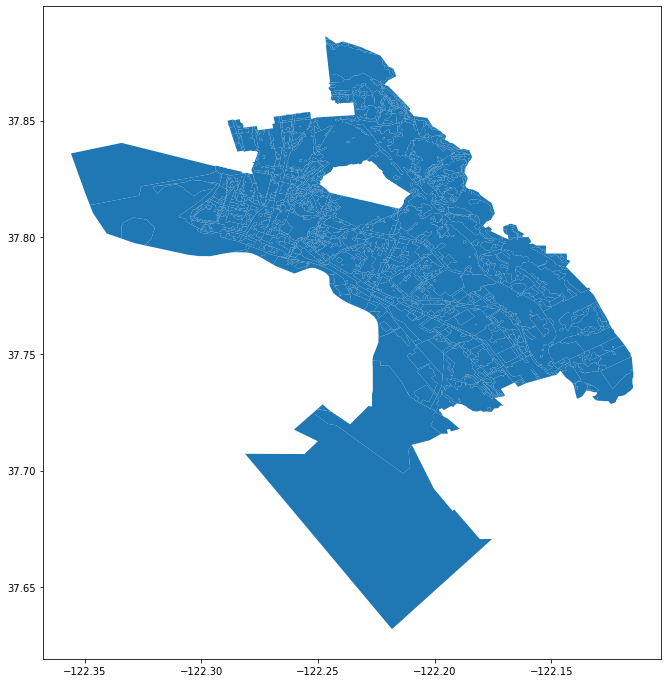

In [237]:
fig, ax = plt.subplots(figsize = (12,12))
oakl.plot(ax = ax)

#### Plotting black carbon data and location of all near-by sources

In [238]:
### legend handles for facilities


maroon_x = mlines.Line2D([], [], color='maroon', marker='x', linestyle='None',
                          markersize=6, label='Alameda')
orange_x = mlines.Line2D([], [], color='darkorange', marker='x', linestyle='None',
                          markersize=6, label='Berkeley')
yellow_x = mlines.Line2D([], [], color='lemonchiffon', marker='x', linestyle='None',
                          markersize=6, label='Oakland')
green_x = mlines.Line2D([], [], color='limegreen', marker='x', linestyle='None',
                          markersize=6, label='Oakland')
blue_x = mlines.Line2D([], [], color='slateblue', marker='x', linestyle='None',
                          markersize=6, label='Oakland')

fuchsia_o = mlines.Line2D([], [], color='fuchsia', marker='o', linestyle='None',
                          markersize=6, label='Traffic ')


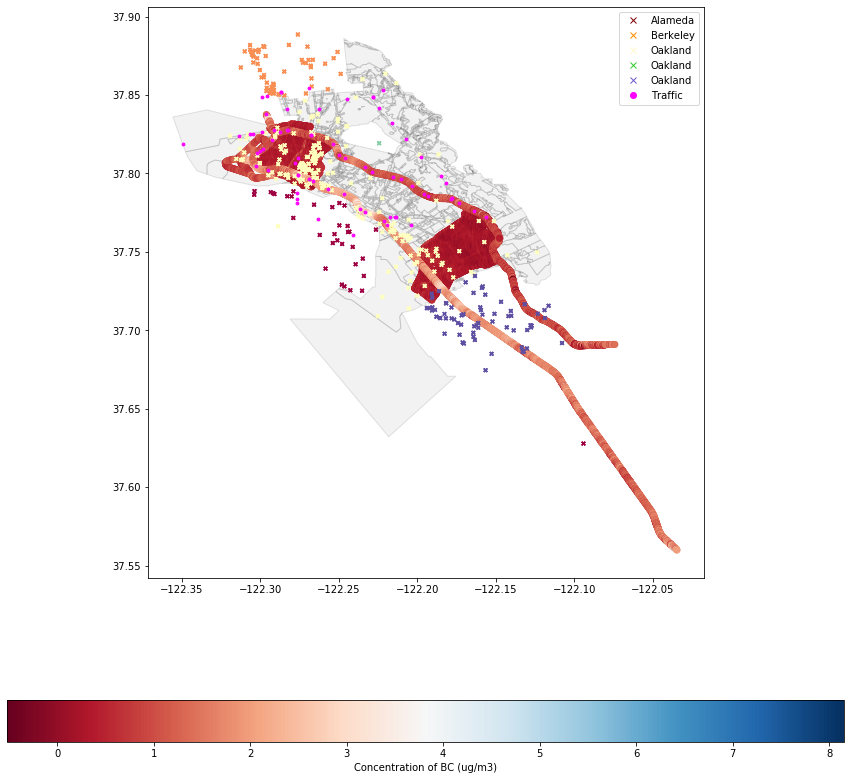

In [239]:

fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df['BC Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df['BC Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.xlim([-122.32,-122.25])
#plt.ylim([37.76,37.9])
#plt.ylim([37.8,37.82])


#cax = fig.add_axes([1, 0.05, 0.03, 0.8])
sm = cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
#sm._A = []
#cbr = fig.colorbar(sm)
#cbr.ax.tick_params(labelsize=20) 
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of BC (ug/m3)')
geo_df_facility.plot(ax=ax, cmap='Spectral', column = 'city', legend = True, marker='x', markersize = 12)
geo_df_traffic.plot(ax=ax, legend=True, marker='o', markersize = 8, color='fuchsia')
plt.legend(handles=[maroon_x, orange_x, yellow_x, green_x, blue_x, fuchsia_o])
#geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
#                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.tight_layout()
#plt.savefig(os.path.join('out','fig.png'),format = 'png',bbox_inches='tight')
plt.show()

#### Plotting NOx data and location of all near-by sources

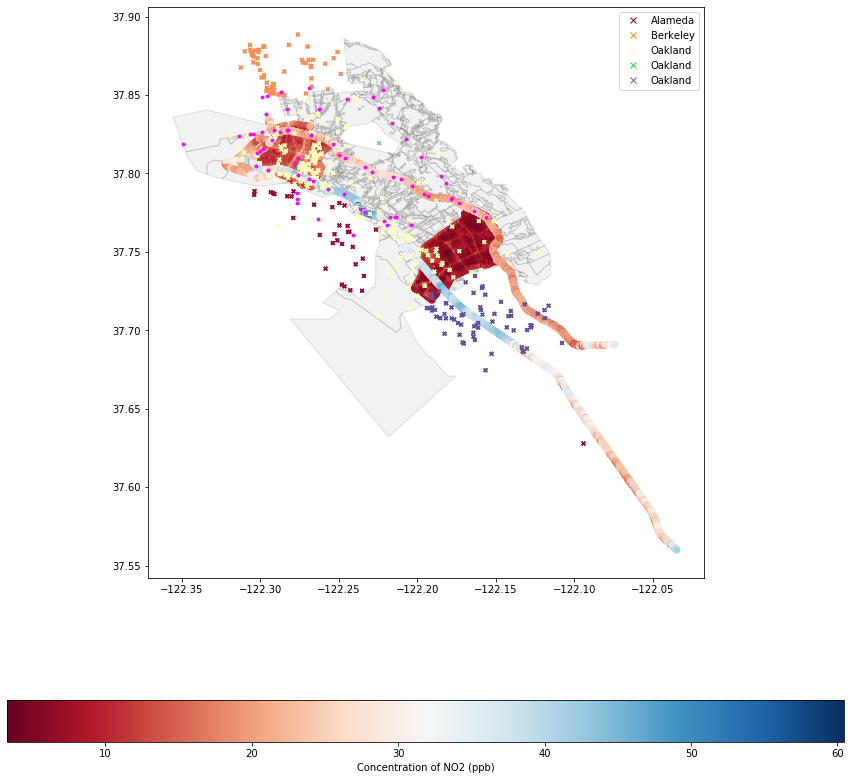

In [240]:
fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df['NO2 Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df['NO2 Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df.plot(ax = ax, column = 'NO2 Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.xlim([-122.25,-122.15])
#plt.ylim([37.7,37.9])


#cax = fig.add_axes([1, 0.05, 0.03, 0.8])
sm = cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
#sm._A = []
#cbr = fig.colorbar(sm)
#cbr.ax.tick_params(labelsize=20) 
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of NO2 (ppb)')
geo_df_facility.plot(ax=ax, cmap='Spectral', column = 'city', legend = True, marker='x', markersize = 12)
geo_df_traffic.plot(ax=ax, legend=True, marker='o', markersize = 8, color='fuchsia')
plt.legend(handles=[maroon_x, orange_x, yellow_x, green_x, blue_x])
#geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
#                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.tight_layout()
#plt.savefig(os.path.join('out','fig.png'),format = 'png',bbox_inches='tight')
plt.show()

## Creating input dataframe - Method 1: 
### Here I find the nearest facility or traffic intersection to each point in the EDF data. The corresponding BC/NOx values or AADT values will be included as an addiitonal column. 

### Find Closest Facility and Traffic Intersection to each point in the EDF data

In [241]:
# Unary Union of the geo_df geometry - Closest Facility

pts = geo_df_facility_PM.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Station name
     nearest = geo_df_facility_PM.geometry == nearest_points(point, pts)[1]
     return geo_df_facility_PM[nearest]['eis facility id'].to_numpy()[0]
geo_df_BC['Nearest_Facility'] = geo_df_BC.apply(lambda row: near(row.geometry), axis=1)

In [242]:
# Unary Union of the geo_df geometry - Closest Facility

pts = geo_df_traffic.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Station name
     nearest = geo_df_traffic.geometry == nearest_points(point, pts)[1]
     return geo_df_traffic[nearest]['Description'].to_numpy()[0]
geo_df_BC['Nearest_Traffic'] = geo_df_BC.apply(lambda row: near(row.geometry), axis=1)

In [243]:
# Merge df_BC with Oak_PM on Facility ID
df_BC_merge = pd.merge(left=df_BC, right=Oak_PM, left_on='Nearest_Facility', right_on='eis facility id')

In [244]:
# Merge above dataframe with traffic
df_BC_merge_traffic = pd.merge(left=df_BC_merge, right=traffic, left_on='Nearest_Traffic', right_on='Description')

In [245]:
df_BC_merge_traffic.head()

,Longitude_x,Latitude_x,BC Value,TimePeriod,geometry_x,Nearest_Facility,Nearest_Traffic,eis facility id,company name_x,latitude,...,city,PM25,PM10,units,geometry_y,Description,AADT,Latitude_y,Longitude_y,geometry
0,-122.322594,37.806781,0.818032,Jun2015-May2016,POINT (-122.32259 37.80678),13747011,SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,13747011,PORT OF OAKLAND,37.80925,...,OAKLAND,0.000225,0.00023,TON,POINT (-122.31539 37.80925),SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,278000,37.823843,-122.313766,POINT (-122.31377 37.82384)
1,-122.322310,37.806150,0.551475,Jun2015-May2016,POINT (-122.32231 37.80615),13747011,SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,13747011,PORT OF OAKLAND,37.80925,...,OAKLAND,0.000225,0.00023,TON,POINT (-122.31539 37.80925),SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,278000,37.823843,-122.313766,POINT (-122.31377 37.82384)
2,-122.322301,37.806420,0.593712,Jun2015-May2016,POINT (-122.32230 37.80642),13747011,SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,13747011,PORT OF OAKLAND,37.80925,...,OAKLAND,0.000225,0.00023,TON,POINT (-122.31539 37.80925),SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,278000,37.823843,-122.313766,POINT (-122.31377 37.82384)
3,-122.322267,37.806689,0.739341,Jun2015-May2016,POINT (-122.32227 37.80669),13747011,SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,13747011,PORT OF OAKLAND,37.80925,...,OAKLAND,0.000225,0.00023,TON,POINT (-122.31539 37.80925),SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,278000,37.823843,-122.313766,POINT (-122.31377 37.82384)
4,-122.322262,37.806720,0.701457,Jun2015-May2016,POINT (-122.32226 37.80672),13747011,SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,13747011,PORT OF OAKLAND,37.80925,...,OAKLAND,0.000225,0.00023,TON,POINT (-122.31539 37.80925),SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,278000,37.823843,-122.313766,POINT (-122.31377 37.82384)


In [246]:
df_BC_merge_traffic.rename(columns={'Latitude_x':'Latitude_Conc','Longitude_x':'Longitude_Conc','latitude':'Latitude_Fac','longitude':'Longitude_Fac','Latitude_y':'Latitude_Traf','Longitude_y':'Longitude_Traf'}, inplace=True)

In [247]:
df_BC_merge_traffic.head()

,Longitude_Conc,Latitude_Conc,BC Value,TimePeriod,geometry_x,Nearest_Facility,Nearest_Traffic,eis facility id,company name_x,Latitude_Fac,...,city,PM25,PM10,units,geometry_y,Description,AADT,Latitude_Traf,Longitude_Traf,geometry
0,-122.322594,37.806781,0.818032,Jun2015-May2016,POINT (-122.32259 37.80678),13747011,SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,13747011,PORT OF OAKLAND,37.80925,...,OAKLAND,0.000225,0.00023,TON,POINT (-122.31539 37.80925),SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,278000,37.823843,-122.313766,POINT (-122.31377 37.82384)
1,-122.322310,37.806150,0.551475,Jun2015-May2016,POINT (-122.32231 37.80615),13747011,SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,13747011,PORT OF OAKLAND,37.80925,...,OAKLAND,0.000225,0.00023,TON,POINT (-122.31539 37.80925),SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,278000,37.823843,-122.313766,POINT (-122.31377 37.82384)
2,-122.322301,37.806420,0.593712,Jun2015-May2016,POINT (-122.32230 37.80642),13747011,SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,13747011,PORT OF OAKLAND,37.80925,...,OAKLAND,0.000225,0.00023,TON,POINT (-122.31539 37.80925),SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,278000,37.823843,-122.313766,POINT (-122.31377 37.82384)
3,-122.322267,37.806689,0.739341,Jun2015-May2016,POINT (-122.32227 37.80669),13747011,SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,13747011,PORT OF OAKLAND,37.80925,...,OAKLAND,0.000225,0.00023,TON,POINT (-122.31539 37.80925),SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,278000,37.823843,-122.313766,POINT (-122.31377 37.82384)
4,-122.322262,37.806720,0.701457,Jun2015-May2016,POINT (-122.32226 37.80672),13747011,SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,13747011,PORT OF OAKLAND,37.80925,...,OAKLAND,0.000225,0.00023,TON,POINT (-122.31539 37.80925),SAN FRANCISCO-OAKLAND BAY BRIDGE TOLL PLAZA,278000,37.823843,-122.313766,POINT (-122.31377 37.82384)


In [248]:
df_BC_merge_traffic.columns

Index(['Longitude_Conc', 'Latitude_Conc', 'BC Value', 'TimePeriod',
       'geometry_x', 'Nearest_Facility', 'Nearest_Traffic', 'eis facility id',
       'company name_x', 'Latitude_Fac', 'Longitude_Fac', 'city', 'PM25',
       'PM10', 'units', 'geometry_y', 'Description', 'AADT', 'Latitude_Traf',
       'Longitude_Traf', 'geometry'],
      dtype='object')

In [249]:
## Create an empty list call dist which stores all the distances between each point (facility and traffic)
dist_fac = []
dist_traf = []

In [250]:
# Defining a function to calculate the distance between two GPS coordinates (latitude and longitude)
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [251]:
for row in df_BC_merge_traffic.iterrows():
    dist_fac.append(distance((row[1]['Latitude_Conc'], row[1]['Longitude_Conc']), (row[1]['Latitude_Fac'], row[1]['Longitude_Fac'])))
    dist_traf.append(distance((row[1]['Latitude_Conc'], row[1]['Longitude_Conc']), (row[1]['Latitude_Traf'], row[1]['Longitude_Traf'])))

In [252]:
df_BC_merge_traffic['Dist_Facility_mi'] = np.array(dist_fac)*0.621
df_BC_merge_traffic['Dist_Traffic_mi'] = np.array(dist_traf)*0.621

In [253]:
## Drop columns from df_BC_merge that are not needed anymore
df_BC_merge_traffic.drop(columns = ['eis facility id','company name_x','city','units', 'Description', 'Nearest_Traffic'], inplace=True)

In [254]:
## Rename columns
df_BC_merge_traffic.rename(columns = {'geometry_x':'Conc_geo', 'geometry_y':'Fac_geo','geometry':'Traf_geo'}, inplace=True)

In [255]:
df_BC_merge_traffic.head()

,Longitude_Conc,Latitude_Conc,BC Value,TimePeriod,Conc_geo,Nearest_Facility,Latitude_Fac,Longitude_Fac,PM25,PM10,Fac_geo,AADT,Latitude_Traf,Longitude_Traf,Traf_geo,Dist_Facility_mi,Dist_Traffic_mi
0,-122.322594,37.806781,0.818032,Jun2015-May2016,POINT (-122.32259 37.80678),13747011,37.80925,-122.31539,0.000225,0.00023,POINT (-122.31539 37.80925),278000,37.823843,-122.313766,POINT (-122.31377 37.82384),0.428407,1.272802
1,-122.322310,37.806150,0.551475,Jun2015-May2016,POINT (-122.32231 37.80615),13747011,37.80925,-122.31539,0.000225,0.00023,POINT (-122.31539 37.80925),278000,37.823843,-122.313766,POINT (-122.31377 37.82384),0.433997,1.307623
2,-122.322301,37.806420,0.593712,Jun2015-May2016,POINT (-122.32230 37.80642),13747011,37.80925,-122.31539,0.000225,0.00023,POINT (-122.31539 37.80925),278000,37.823843,-122.313766,POINT (-122.31377 37.82384),0.424656,1.290023
3,-122.322267,37.806689,0.739341,Jun2015-May2016,POINT (-122.32227 37.80669),13747011,37.80925,-122.31539,0.000225,0.00023,POINT (-122.31539 37.80925),278000,37.823843,-122.313766,POINT (-122.31377 37.82384),0.414775,1.272057
4,-122.322262,37.806720,0.701457,Jun2015-May2016,POINT (-122.32226 37.80672),13747011,37.80925,-122.31539,0.000225,0.00023,POINT (-122.31539 37.80925),278000,37.823843,-122.313766,POINT (-122.31377 37.82384),0.413605,1.269966


## Creating input dataframe - Method 2: 
### Here we identify facilities and traffic intersections that are within 1,000 ft of each point. There will be one column in the dataframe and values of that column will be the distance between the concentration point and the facility, and second column will the emissions. 

### Here, I filter for facilities only in Oakland or San Leandro

In [256]:
Oak_PM_filter = Oak_PM[(Oak_PM['city'] == 'OAKLAND') | (Oak_PM['city'] == 'SAN LEANDRO')]

In [260]:
Oak_PM.head()

,eis facility id,company name_x,latitude,longitude,city,PM25,PM10,units,geometry
0,126911,PACIFIC BELL,37.76685,-122.24972,ALAMEDA,0.000731,0.000749,TON,POINT (-122.24972 37.76685)
1,127111,PACIFIC BELL,37.86771,-122.26784,BERKELEY,0.002173,0.002226,TON,POINT (-122.26784 37.86771)
2,127511,PACIFIC BELL,37.80603,-122.26946,OAKLAND,0.008291,0.008494,TON,POINT (-122.26946 37.80603)
3,127611,PACIFIC BELL,37.78422,-122.22241,OAKLAND,0.000706,0.000724,TON,POINT (-122.22241 37.78422)
4,127711,PACIFIC BELL,37.83336,-122.26307,OAKLAND,0.001554,0.001592,TON,POINT (-122.26307 37.83336)
